In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os
import pandas as pd
os.environ['SPARK_HOME']="/Users/jayasabarishreddyremala/Desktop/NYU/spark"
os.environ['PYSPARK_DRIVER_PYTHON']='jupyter' 
os.environ['PYSPARK_DRIVER_PYTHON_OPS']='lab'
os.environ['PYSPARK_PYTHON']='python'
import plotly.express as px


In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "4g").appName("sparkan").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/08 22:00:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
mvcdata2 = spark.read.format('csv').options(header='true',inferschema='true').load("nonull.csv")
#mvcdata2.show()

In [4]:
mvcdata2.createOrReplaceTempView("allData")

23/12/08 22:00:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
mvcdata2.count()

1839003

# Analysis on contributing factors - accident count in each borough

In [6]:
cf_classification_sql = """
SELECT 
    *, 
    CASE 
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Brakes Defective', 'Steering Failure', 'Tire Failure/Inadequate', 
            'Accelerator Defective', 'Tow Hitch Defective', 'Tinted Windows', 
            'Windshield Inadequate'
        ) THEN 'Mechanical Failure'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Pavement Slippery', 'Obstruction/Debris', 'Pavement Defective', 
            'Lane marking Improper/Inadequate', 'Traffice Control Device Improper/Non-Working'
        ) THEN 'Traffic System Failure'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Alcohol Involvement', 'Prescription Medication', 'Drugs(illegal)', 'Drugs(Illegal)', 'Drugs (illegal)','Drugs (Illegal)'
        ) THEN 'Substance Abuse'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Other Electronic Device', 'Cell Phone(hand-held)', 'Cell Phone (hand-Held)', 
            'Cell Phone(hands-free)', 'Using on Board Navigation Device', 'Texting', 
            'Listening/Using Headphones','Cell Phone (hands-free)','Cell Phone (hand-held)','Cell Phone (hand-Held)'
        ) THEN 'Technological Intervention'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Driver Inattention/Distraction') THEN 'Driver Inattention'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Failure to Yield Right-of-Way') THEN 'Right-way Rule'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Following Too Closely', 'Passing Too Closely') THEN 'Following Too Closely'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Backing Unsafely', 'Passing or Lane Usage Improper', 'Turning Improperly', 
            'Unsafe Lane Changing', 'Driver Inexperience', 'Aggressive Driving/Road Rage', 
            'Eating or Drinking'
        ) THEN 'Driver Incompetence'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Traffic Control Disregarded', 'Unsafe Speed') THEN 'Traffic Rule Avoidance'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN (
            'Fatigued/Drowsy', 'Lost Consciousness', 'Fell Asleep', 'Illness', 'Illnes', 
            'Shoulders Defective/Improper', 'Physical Disability'
        ) THEN 'Biological Effects'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Other Vehicular', 'Reaction to Uninvolved Vehicle') THEN 'Other Vehicle Intervention'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Glare', 'Other Lighting Defects', 'Headlights Defective') THEN 'Lighting Reasons'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('Passenger Distraction', 'Outside Car Distraction') THEN 'Distraction'
        WHEN CONTRIBUTING_FACTOR_VEHICLE_1 IN ('1', '80', 'Unspecified','') THEN 'Unspecified'
        ELSE CONTRIBUTING_FACTOR_VEHICLE_1
    END AS cf_Classification 
FROM 
    allData
"""


In [7]:
cf_class = spark.sql(cf_classification_sql)

In [8]:
cf_class.createOrReplaceTempView("cfData")

In [9]:
cf_class_sql="""
SELECT * from cfData WHERE cf_Classification!='Unspecified' or cf_Classification!=NULL
"""

In [10]:
cf_class=spark.sql(cf_class_sql)

In [11]:
cf_class.count()

1209578

In [12]:
cf_class.repartition(1).write.mode("overwrite").format('csv').options(header='true').save("cf_classification")

In [13]:
cf_class.show(10)

+----------+-------------------+-------+--------+---------+----------+--------------------+-----------------+---------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------+--------------------+
|CRASH_DATE|         CRASH_TIME|BOROUGH|ZIP_CODE| LATITUDE| LONGITUDE|      ON_STREET_NAME|CROSS_STREET_NAME|OFF_STREET_NAME|NUMBER_OF_PERSONS_INJURED|NUMBER_OF_PERSONS_KILLED|NUMBER_OF_PEDESTRIANS_INJURED|NUMBER_OF_PEDESTRIANS_KILLED|NUMBER_OF_CYCLIST_INJURED|NUMBER_OF_CYCLIST_KILLED|NUMBER_OF_MOTORIST_INJURED|NUMBER_OF_MOTORIST_KILLED|CONTRIBUTING_FACTOR_V

# cf classification - no of accidents

In [14]:
cf_classification_data = spark.read.format('csv').options(header='true',inferschema='true').load("cf_classification.csv")

In [15]:
cf_classification_data.createOrReplaceTempView("cfData")

# No of accidents VS cf_classification_types

In [16]:
cf_classsification_no_of_accidents="""
select cf_Classification, count(*) AS no_of_accidents from cfData group by cf_Classification
"""

In [17]:
cf_classsification_no_of_accidents = spark.sql(cf_classsification_no_of_accidents)

In [19]:
cf_classsification_no_of_accidents.show(40)

+--------------------+---------------+
|   cf_Classification|no_of_accidents|
+--------------------+---------------+
|Following Too Clo...|         142602|
|Driverless/Runawa...|           1201|
|Using On Board Na...|            126|
|Traffic System Fa...|          22593|
|Traffic Rule Avoi...|          58204|
|     Substance Abuse|          34353|
|Other Vehicle Int...|          75089|
|   Oversized Vehicle|          11338|
|Lane Marking Impr...|            829|
| Driver Incompetence|         240604|
|  Driver Inattention|         373817|
|  Mechanical Failure|          12141|
|      Right-way Rule|         112593|
|View Obstructed/L...|          12546|
|Technological Int...|           2839|
|         Distraction|          18028|
|Failure to Keep R...|           2901|
|Pedestrian/Bicycl...|           8946|
|  Biological Effects|          71552|
|Traffic Control D...|            742|
|      Animals Action|           1382|
|   Vehicle Vandalism|            127|
|    Lighting Reasons|   

# No of cf_classification_types

In [20]:
cfclassification_types="""
SELECT DISTINCT cf_Classification from cfData
"""

In [21]:
cf_classsification_types = spark.sql(cfclassification_types)

In [22]:
cf_classsification_types.show(40)

+--------------------+
|   cf_Classification|
+--------------------+
|Following Too Clo...|
|Driverless/Runawa...|
|Using On Board Na...|
|Traffic System Fa...|
|Traffic Rule Avoi...|
|     Substance Abuse|
|Other Vehicle Int...|
|   Oversized Vehicle|
|Lane Marking Impr...|
| Driver Incompetence|
|  Driver Inattention|
|  Mechanical Failure|
|      Right-way Rule|
|View Obstructed/L...|
|Technological Int...|
|         Distraction|
|Failure to Keep R...|
|Pedestrian/Bicycl...|
|  Biological Effects|
|Traffic Control D...|
|      Animals Action|
|   Vehicle Vandalism|
|    Lighting Reasons|
|Reaction to Other...|
+--------------------+



In [23]:
cf_classsification_types.repartition(1).write.mode("overwrite").format('csv').options(header='true').save("cf_classification_types")

# No of classification types

In [24]:
cf_classsification_no_of_accidents.count()

24

# Borough based classification VS No of accidents

In [25]:
borough_based_classification="""
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred
FROM cfData
GROUP BY cf_Classification, B1
ORDER BY B1,cf_Classification;
"""

In [26]:
borough_based_classification=spark.sql(borough_based_classification)

In [27]:
borough_based_classification.show(500)

+-------------+--------------------+------------------------+
|           B1|   cf_Classification|No_of_accidents_occurred|
+-------------+--------------------+------------------------+
|        BRONX|      Animals Action|                     385|
|        BRONX|  Biological Effects|                    6231|
|        BRONX|         Distraction|                    2078|
|        BRONX|  Driver Inattention|                   43831|
|        BRONX| Driver Incompetence|                   29633|
|        BRONX|Driverless/Runawa...|                     239|
|        BRONX|Failure to Keep R...|                     320|
|        BRONX|Following Too Clo...|                   15154|
|        BRONX|Lane Marking Impr...|                     113|
|        BRONX|    Lighting Reasons|                     729|
|        BRONX|  Mechanical Failure|                    1767|
|        BRONX|Other Vehicle Int...|                   11782|
|        BRONX|   Oversized Vehicle|                    1237|
|       

In [28]:
borough_based_classification_pd=borough_based_classification.toPandas()

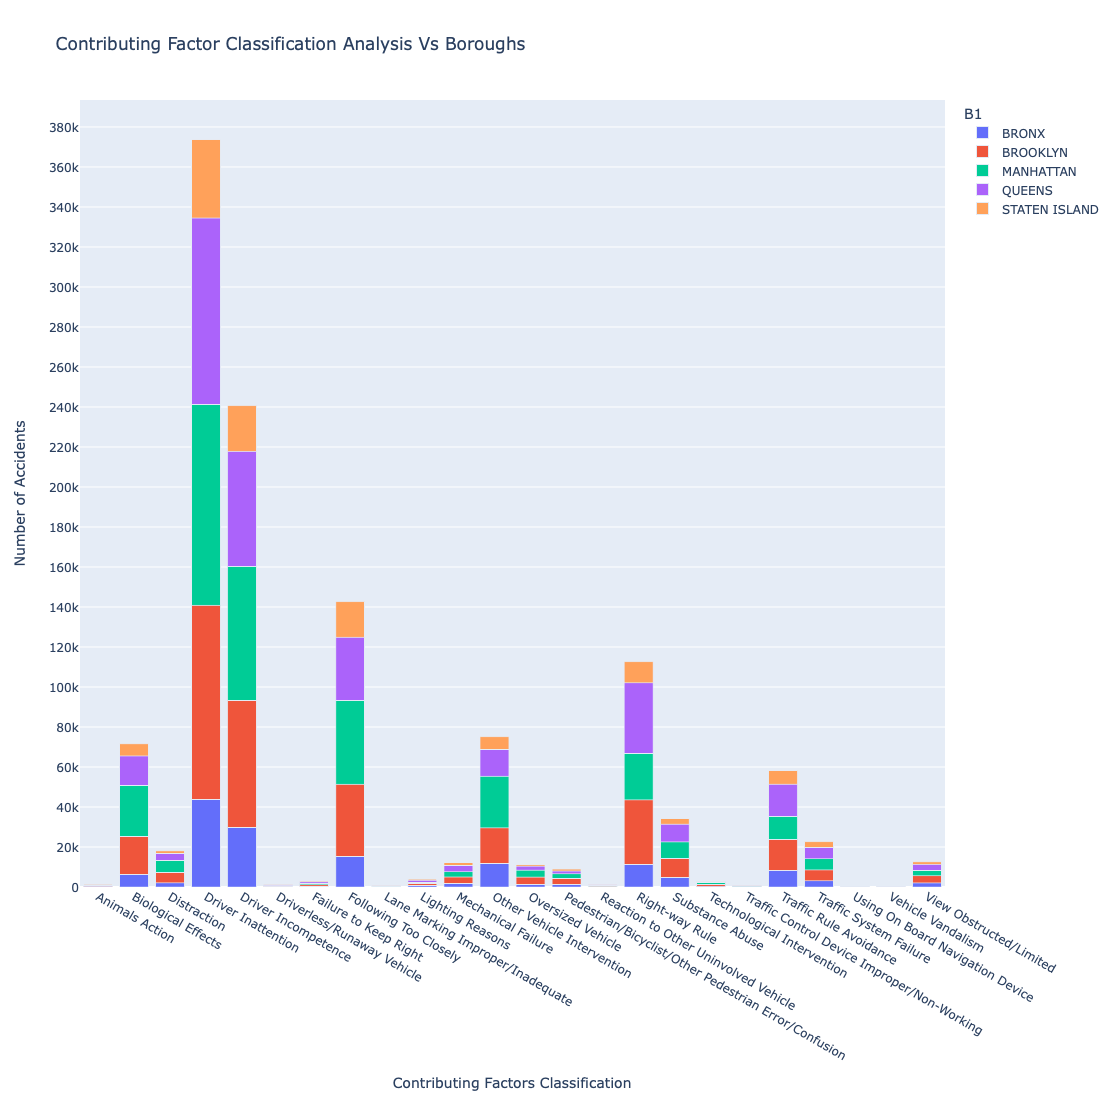

In [29]:
# Assuming borough_based_classification_pd is your DataFrame with columns cf_Classification, No_of_accidents_occurred, and B1
fig = px.bar(
    borough_based_classification_pd,
    x="cf_Classification",
    y="No_of_accidents_occurred",
    color="B1",  # Specify the column for hue
    title="Contributing Factor Classification Analysis Vs Boroughs"
)

# Customize the layout
fig.update_layout(
    height=1100,
    width=1100,
    xaxis_title="Contributing Factors Classification",
    yaxis_title="Number of Accidents",
    showlegend=True,
    yaxis=dict(
        dtick=20000  # Set the desired interval on the y-axis
    )
)

# Show the plot
fig.show()


### For Each cf Classification sum of all accidents

In [30]:
cf_based_classification_sumofaccidents="""
SELECT cf_Classification,
       COUNT(*) AS Acc_occurred_in_allboroughs
FROM cfData
GROUP BY cf_Classification
ORDER BY cf_Classification;
"""

In [31]:
cf_based_classification_sumofaccidents=spark.sql(cf_based_classification_sumofaccidents)

In [32]:
cf_based_classification_sumofaccidents.show(30)

+--------------------+---------------------------+
|   cf_Classification|Acc_occurred_in_allboroughs|
+--------------------+---------------------------+
|      Animals Action|                       1382|
|  Biological Effects|                      71552|
|         Distraction|                      18028|
|  Driver Inattention|                     373817|
| Driver Incompetence|                     240604|
|Driverless/Runawa...|                       1201|
|Failure to Keep R...|                       2901|
|Following Too Clo...|                     142602|
|Lane Marking Impr...|                        829|
|    Lighting Reasons|                       3879|
|  Mechanical Failure|                      12141|
|Other Vehicle Int...|                      75089|
|   Oversized Vehicle|                      11338|
|Pedestrian/Bicycl...|                       8946|
|Reaction to Other...|                       1146|
|      Right-way Rule|                     112593|
|     Substance Abuse|         

In [33]:
cf_based_classification_sumofaccidents_pd = cf_based_classification_sumofaccidents.toPandas()

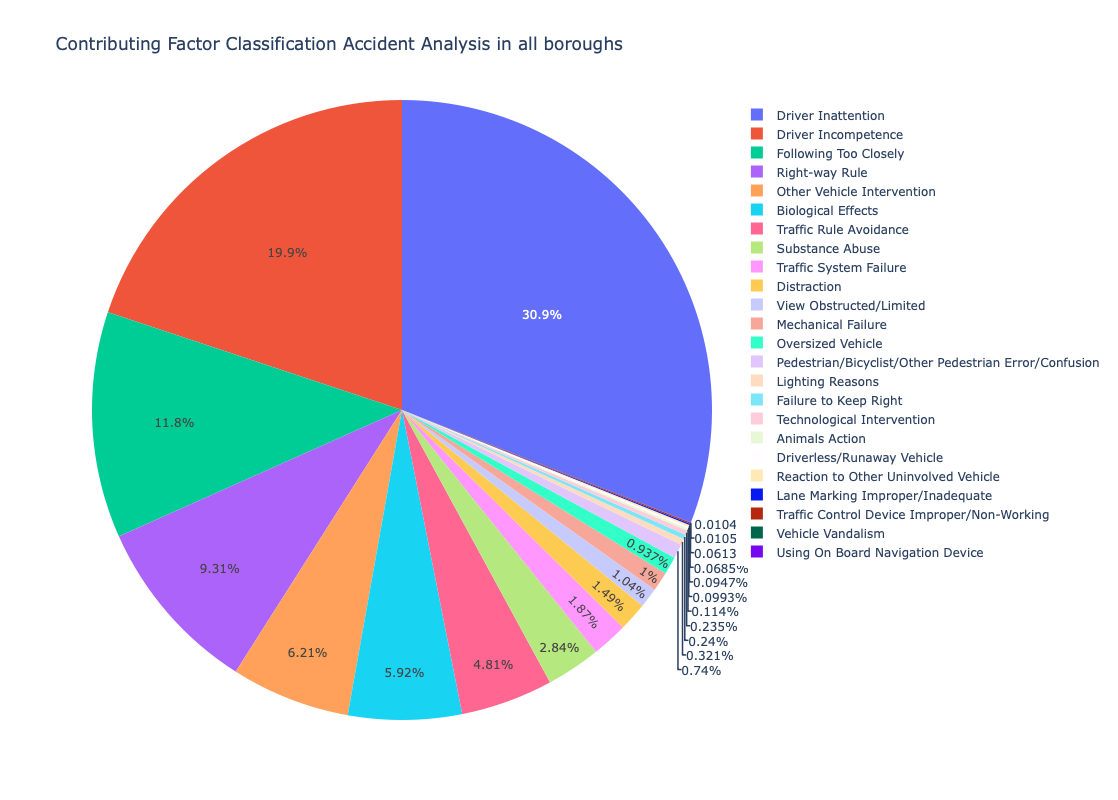

In [34]:
fig = px.pie(cf_based_classification_sumofaccidents_pd, names="cf_Classification", values="Acc_occurred_in_allboroughs", title="Contributing Factor Classification Accident Analysis in all boroughs")

# Customize the layout
fig.update_layout(height=800, width=1100, showlegend=True)

# Show the plot
fig.show()

## For Bronx

In [35]:
bronx_based_cfclassification = """
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred,
       ROUND(((COUNT(*) / (SELECT COUNT(*) FROM cfData)) * 100),2) AS Accident_Percentage_wrt_All_Boroughs
FROM cfData
WHERE B1 = 'BRONX'
GROUP BY cf_Classification, B1
ORDER BY cf_Classification;

"""

In [36]:
bronx_based_cfclassification = spark.sql(bronx_based_cfclassification)

In [37]:
bronx_based_cfclassification.show(30)

+-----+--------------------+------------------------+------------------------------------+
|   B1|   cf_Classification|No_of_accidents_occurred|Accident_Percentage_wrt_All_Boroughs|
+-----+--------------------+------------------------+------------------------------------+
|BRONX|      Animals Action|                     385|                                0.03|
|BRONX|  Biological Effects|                    6231|                                0.52|
|BRONX|         Distraction|                    2078|                                0.17|
|BRONX|  Driver Inattention|                   43831|                                3.62|
|BRONX| Driver Incompetence|                   29633|                                2.45|
|BRONX|Driverless/Runawa...|                     239|                                0.02|
|BRONX|Failure to Keep R...|                     320|                                0.03|
|BRONX|Following Too Clo...|                   15154|                                1.25|

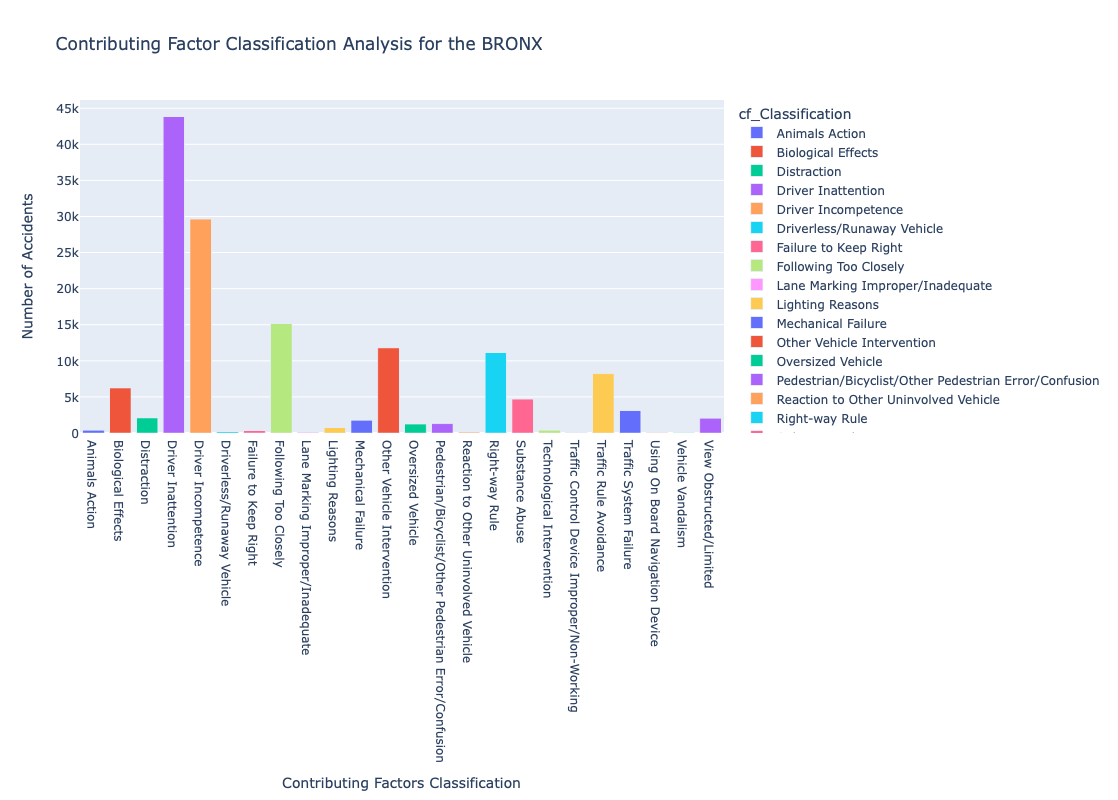

In [38]:
bronx_based_cfclassification_pd = bronx_based_cfclassification.toPandas()


# Assuming dl_status_pandas is your DataFrame with columns CONTRIBUTING_FACTOR_1 and ACCIDENTS
fig = px.bar(bronx_based_cfclassification_pd,color="cf_Classification", x="cf_Classification", y="No_of_accidents_occurred", title="Contributing Factor Classification Analysis for the BRONX")

# Customize the layout
fig.update_layout(height=800, width=1100, xaxis_title="Contributing Factors Classification", yaxis_title="Number of Accidents")

# Show the plot
fig.show()


## For Brooklyn

In [39]:
brooklyn_based_cfclassification = """
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred,
       ROUND(((COUNT(*) / (SELECT COUNT(*) FROM cfData)) * 100),2) AS Accident_Percentage_wrt_All_Boroughs
FROM cfData
WHERE B1 = 'BROOKLYN'
GROUP BY cf_Classification, B1
ORDER BY cf_Classification;
"""

In [40]:
brooklyn_based_cfclassification = spark.sql(brooklyn_based_cfclassification)

In [41]:
brooklyn_based_cfclassification.show(30)

+--------+--------------------+------------------------+------------------------------------+
|      B1|   cf_Classification|No_of_accidents_occurred|Accident_Percentage_wrt_All_Boroughs|
+--------+--------------------+------------------------+------------------------------------+
|BROOKLYN|      Animals Action|                     244|                                0.02|
|BROOKLYN|  Biological Effects|                   18944|                                1.57|
|BROOKLYN|         Distraction|                    5156|                                0.43|
|BROOKLYN|  Driver Inattention|                   97057|                                8.02|
|BROOKLYN| Driver Incompetence|                   63698|                                5.27|
|BROOKLYN|Driverless/Runawa...|                     379|                                0.03|
|BROOKLYN|Failure to Keep R...|                     778|                                0.06|
|BROOKLYN|Following Too Clo...|                   36247|    

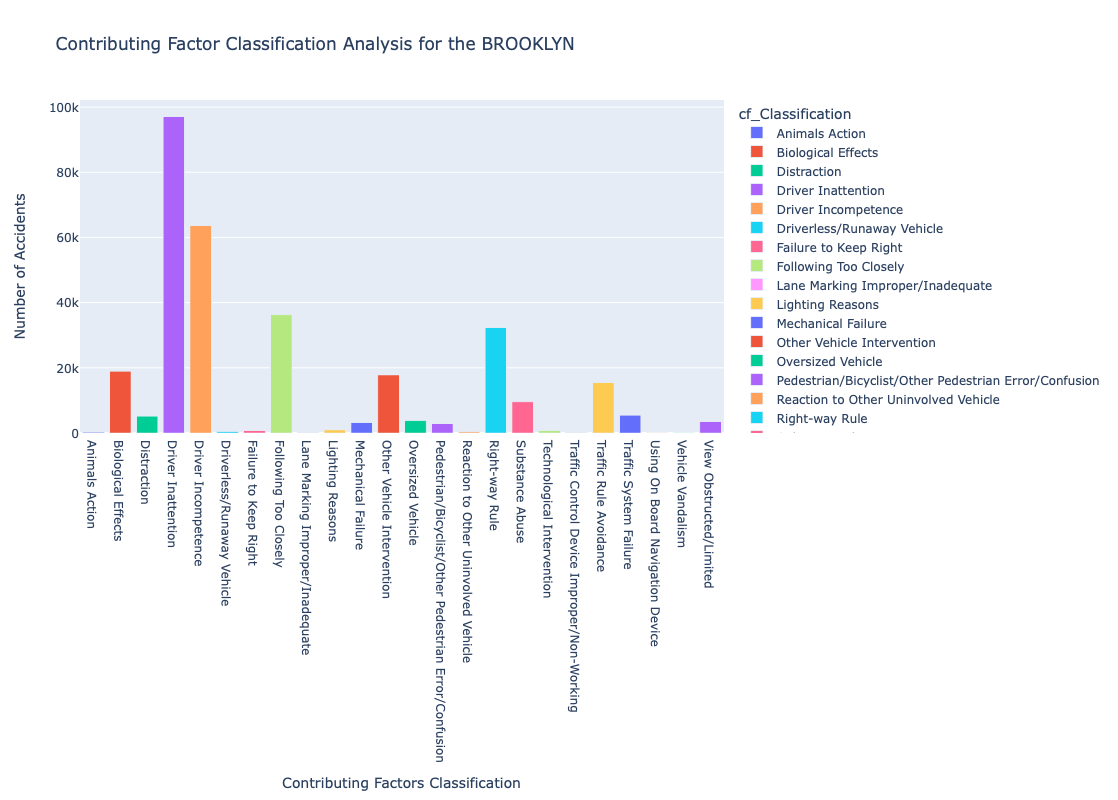

In [42]:
brooklyn_based_cfclassification_pd = brooklyn_based_cfclassification.toPandas()


# Assuming dl_status_pandas is your DataFrame with columns CONTRIBUTING_FACTOR_1 and ACCIDENTS
fig = px.bar(brooklyn_based_cfclassification_pd,color="cf_Classification", x="cf_Classification", y="No_of_accidents_occurred", title="Contributing Factor Classification Analysis for the BROOKLYN")

# Customize the layout
fig.update_layout(height=800, width=1100, xaxis_title="Contributing Factors Classification", yaxis_title="Number of Accidents")

# Show the plot
fig.show()

## For Manhattan

In [43]:
manhattan_based_cfclassification = """
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred,
       ROUND(((COUNT(*) / (SELECT COUNT(*) FROM cfData)) * 100),2) AS Accident_Percentage_wrt_All_Boroughs
FROM cfData
WHERE B1 = 'MANHATTAN'
GROUP BY cf_Classification, B1
ORDER BY cf_Classification;
"""

In [44]:
manhattan_based_cfclassification=spark.sql(manhattan_based_cfclassification)

In [45]:
manhattan_based_cfclassification.show(30)

+---------+--------------------+------------------------+------------------------------------+
|       B1|   cf_Classification|No_of_accidents_occurred|Accident_Percentage_wrt_All_Boroughs|
+---------+--------------------+------------------------+------------------------------------+
|MANHATTAN|      Animals Action|                     161|                                0.01|
|MANHATTAN|  Biological Effects|                   25463|                                2.11|
|MANHATTAN|         Distraction|                    6027|                                 0.5|
|MANHATTAN|  Driver Inattention|                  100350|                                 8.3|
|MANHATTAN| Driver Incompetence|                   66878|                                5.53|
|MANHATTAN|Driverless/Runawa...|                     207|                                0.02|
|MANHATTAN|Failure to Keep R...|                     686|                                0.06|
|MANHATTAN|Following Too Clo...|                  

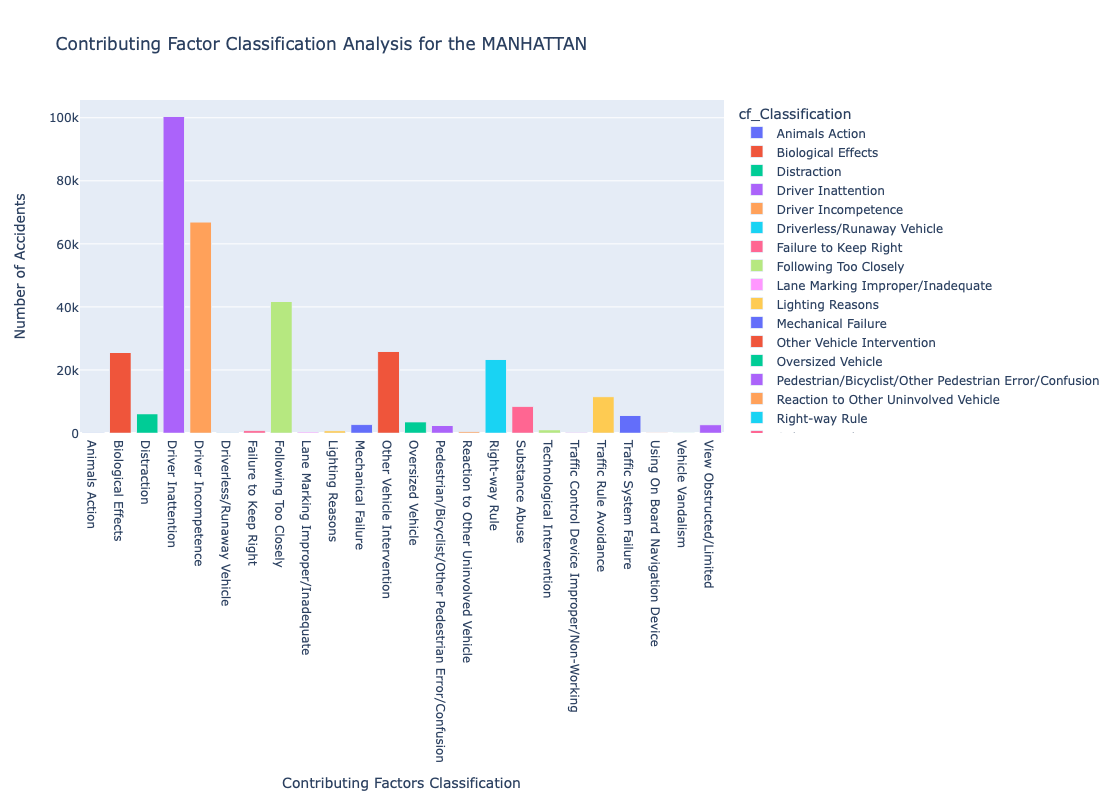

In [46]:
manhattan_based_cfclassification_pd = manhattan_based_cfclassification.toPandas()


# Assuming dl_status_pandas is your DataFrame with columns CONTRIBUTING_FACTOR_1 and ACCIDENTS
fig = px.bar(manhattan_based_cfclassification_pd,color="cf_Classification", x="cf_Classification", y="No_of_accidents_occurred", title="Contributing Factor Classification Analysis for the MANHATTAN")

# Customize the layout
fig.update_layout(height=800, width=1100, xaxis_title="Contributing Factors Classification", yaxis_title="Number of Accidents")

# Show the plot
fig.show()

## For Queens

In [47]:
queens_based_cfclassification = """
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred,
       ROUND(((COUNT(*) / (SELECT COUNT(*) FROM cfData)) * 100),2) AS Accident_Percentage_wrt_All_Boroughs
FROM cfData
WHERE B1 = 'QUEENS'
GROUP BY cf_Classification, B1
ORDER BY cf_Classification;
"""

In [48]:
queens_based_cfclassification=spark.sql(queens_based_cfclassification)

In [49]:
queens_based_cfclassification.show(30)

+------+--------------------+------------------------+------------------------------------+
|    B1|   cf_Classification|No_of_accidents_occurred|Accident_Percentage_wrt_All_Boroughs|
+------+--------------------+------------------------+------------------------------------+
|QUEENS|      Animals Action|                     321|                                0.03|
|QUEENS|  Biological Effects|                   14902|                                1.23|
|QUEENS|         Distraction|                    3454|                                0.29|
|QUEENS|  Driver Inattention|                   93269|                                7.71|
|QUEENS| Driver Incompetence|                   57667|                                4.77|
|QUEENS|Driverless/Runawa...|                     252|                                0.02|
|QUEENS|Failure to Keep R...|                     785|                                0.06|
|QUEENS|Following Too Clo...|                   31714|                          

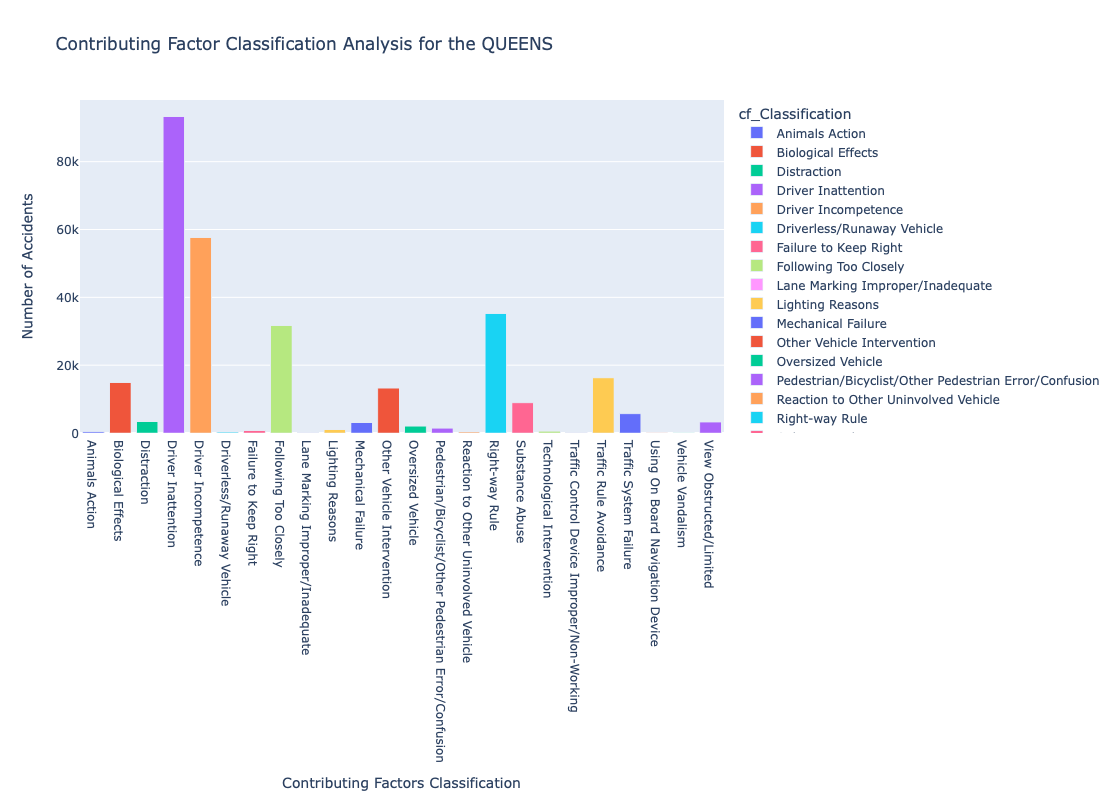

In [50]:
queens_based_cfclassification_pd = queens_based_cfclassification.toPandas()


# Assuming dl_status_pandas is your DataFrame with columns CONTRIBUTING_FACTOR_1 and ACCIDENTS
fig = px.bar(queens_based_cfclassification_pd,color="cf_Classification", x="cf_Classification", y="No_of_accidents_occurred", title="Contributing Factor Classification Analysis for the QUEENS")

# Customize the layout
fig.update_layout(height=800, width=1100, xaxis_title="Contributing Factors Classification", yaxis_title="Number of Accidents")

# Show the plot
fig.show()

## For Staten Island

In [51]:
staten_island_based_cfclassification = """
SELECT B1,
       cf_Classification,
       COUNT(*) AS No_of_accidents_occurred,
       ROUND(((COUNT(*) / (SELECT COUNT(*) FROM cfData)) * 100),2) AS Accident_Percentage_wrt_All_Boroughs
FROM cfData
WHERE B1 = 'STATEN ISLAND'
GROUP BY cf_Classification, B1
ORDER BY cf_Classification;
"""

In [52]:
staten_island_based_cfclassification=spark.sql(staten_island_based_cfclassification)

In [53]:
staten_island_based_cfclassification.show(30)

+-------------+--------------------+------------------------+------------------------------------+
|           B1|   cf_Classification|No_of_accidents_occurred|Accident_Percentage_wrt_All_Boroughs|
+-------------+--------------------+------------------------+------------------------------------+
|STATEN ISLAND|      Animals Action|                     271|                                0.02|
|STATEN ISLAND|  Biological Effects|                    6012|                                 0.5|
|STATEN ISLAND|         Distraction|                    1313|                                0.11|
|STATEN ISLAND|  Driver Inattention|                   39310|                                3.25|
|STATEN ISLAND| Driver Incompetence|                   22728|                                1.88|
|STATEN ISLAND|Driverless/Runawa...|                     124|                                0.01|
|STATEN ISLAND|Failure to Keep R...|                     332|                                0.03|
|STATEN IS

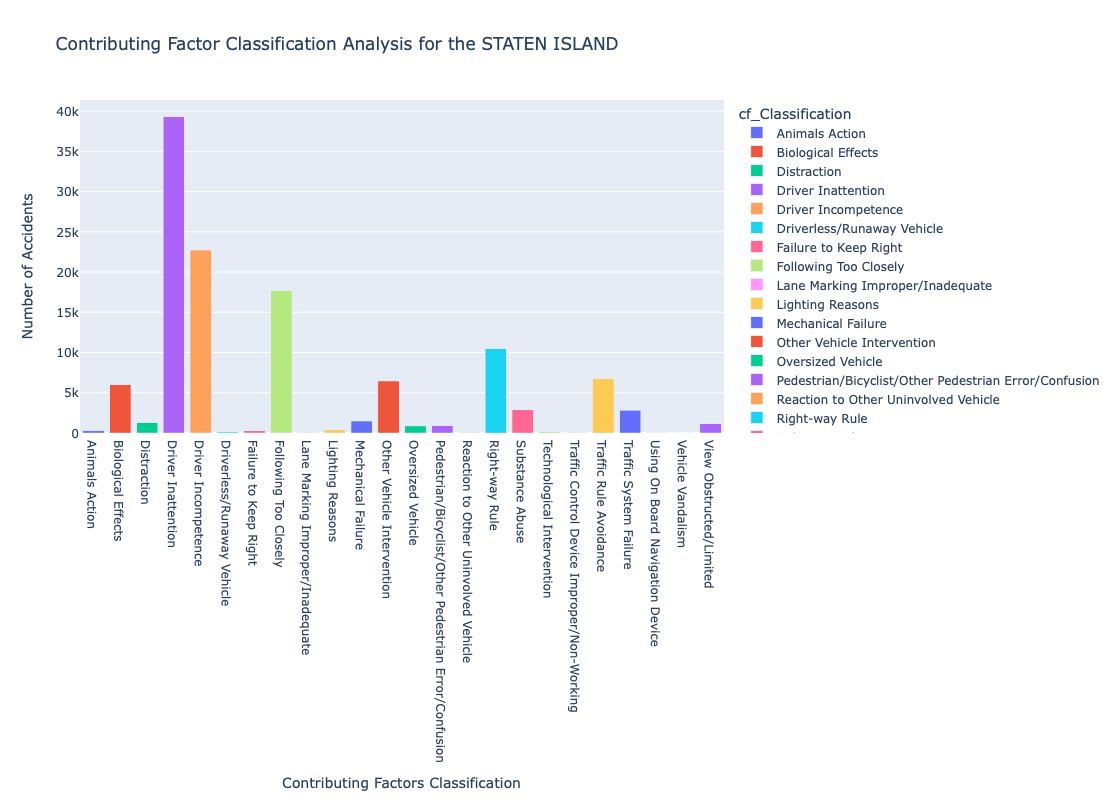

In [54]:
staten_island_based_cfclassification_pd = staten_island_based_cfclassification.toPandas()


# Assuming dl_status_pandas is your DataFrame with columns CONTRIBUTING_FACTOR_1 and ACCIDENTS
fig = px.bar(staten_island_based_cfclassification_pd,color="cf_Classification", x="cf_Classification", y="No_of_accidents_occurred", title="Contributing Factor Classification Analysis for the STATEN ISLAND")

# Customize the layout
fig.update_layout(height=800, width=1100, xaxis_title="Contributing Factors Classification", yaxis_title="Number of Accidents")

# Show the plot
fig.show()